In [1]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import matplotlib

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

plt.style.use(["science", "ieee"])
api = wandb.Api()
out_dir = "../output/analysis"
os.makedirs(out_dir, exist_ok=True)

# Project is specified by <entity/project-name>
runs = api.runs("kobybibas/pnml_for_dnn")


In [2]:
# prune 0.0
run = api.run("kobybibas/pnml_for_dnn/2ynrwl9c")
run.file("res_df.pkl").download(replace=True)
prune_0_df = pd.read_pickle("res_df.pkl")

# prune 0.7
run = api.run("kobybibas/pnml_for_dnn/1zbb5xj0")
run.file("res_df.pkl").download(replace=True)
prune_1_df = pd.read_pickle("res_df.pkl")

# prune 0.95
run = api.run("kobybibas/pnml_for_dnn/mvp15tzb")
run.file("res_df.pkl").download(replace=True)
prune_2_df = pd.read_pickle("res_df.pkl")

# prune 0.99
run = api.run("kobybibas/pnml_for_dnn/3ha6izbo")
run.file("res_df.pkl").download(replace=True)
prune_3_df = pd.read_pickle("res_df.pkl")

df_dict = {
    "0.0": prune_0_df,
    "0.75": prune_1_df,
    "0.95": prune_2_df,
    "0.99": prune_3_df,
}


In [3]:
performance_list = []
for prune_amount, df in df_dict.items():
    performance_list.append(
        {
            "Prune amount": prune_amount,
            "pNML accuracy (%)": 100 * df["pnml_is_correct"].mean(),
            "ERM accuracy (%)": 100 * df["erm_is_correct"].mean(),
            "pNML logloss": df["pnml_logloss"].mean(),
            "ERM logloss": df["erm_logloss"].mean(),
            "pNML max logloss": df["pnml_logloss"].max(),
            "ERM max logloss": df["erm_logloss"].max(),
            "Regret": df["pnml_regret"].mean(),
            'Test set size': len(df)
        }
    )

performance_df = pd.DataFrame(performance_list).round(2).set_index("Prune amount")
performance_df


,pNML accuracy (%),ERM accuracy (%),pNML logloss,ERM logloss,pNML max logloss,ERM max logloss,Regret,Test set size
Prune amount,,,,,,,,
0.0,85.47,95.92,0.69,0.15,0.70,15.34,0.69,1005
0.75,87.30,95.87,0.69,0.19,0.76,20.27,0.69,945
0.95,92.55,95.27,0.67,0.17,0.71,13.04,0.67,846
0.99,92.19,92.98,0.22,0.21,4.48,4.90,0.06,627


Max regret_max=0.693. Theoretical max: np.log(2)=0.693. Difference=regret_max-np.log(2)=1.904654323148236e-09 


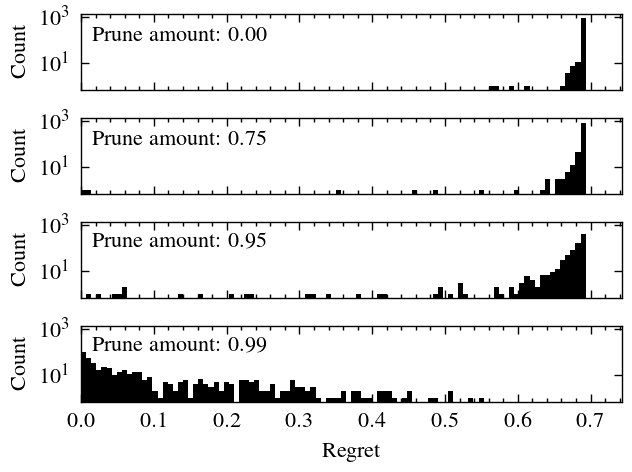

In [4]:
bins = np.linspace(0.0, np.log(2), 100)

regret_max = max([df["pnml_regret"].max() for df in df_dict.values()])
print(
    f"Max {regret_max=:.3f}. Theoretical max: {np.log(2)=:.3f}. Difference={regret_max-np.log(2)=} "
)
fig, axs = plt.subplots(len(df_dict), 1, dpi=200, sharex=True, sharey=True)

for i, (prune_amount, df) in enumerate(df_dict.items()):
    ax = axs[i]
    ax.hist(
        df["pnml_regret"], bins=bins, alpha=1.0, color=f"C0",
    )
    ax.set_yscale("log")
    ax.set_ylabel("Count")
    ax.text(
        0.02,
        0.85,
        f"Prune amount: {float(prune_amount):3.2f}",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
axs[-1].set_xlabel("Regret")
plt.xlim(0, np.log(2) + 0.05)
plt.tight_layout()
plt.savefig(osp.join(out_dir, "regret_hist.pdf"))
plt.show()


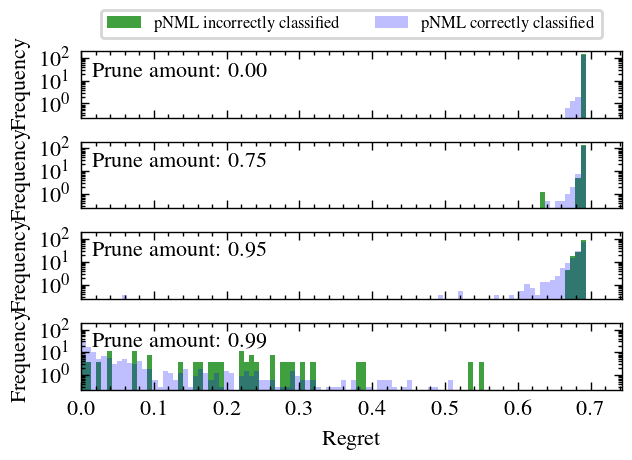

In [6]:
# Regret for pNML correctly classifed samples
bins = np.linspace(0.0, np.log(2), 100)
fig, axs = plt.subplots(len(df_dict), 1, dpi=200, sharex=True, sharey=True)

for i, (prune_amount, df) in enumerate(df_dict.items()):
    regret_for_correct = df[df['pnml_is_correct']==True]["pnml_regret"]
    regret_for_incorrect = df[df['pnml_is_correct']==False]["pnml_regret"]

    ax = axs[i]
    ax.hist(
        regret_for_incorrect, bins=bins, alpha=0.75, color=f"C3",label='pNML incorrectly classified',density=True
    )
    ax.hist(
        regret_for_correct, bins=bins, alpha=0.25, color=f"C2",label='pNML correctly classified',density=True
    )

    ax.set_yscale("log")
    ax.set_ylabel("Frequency")
    ax.text(
        0.02,
        0.85,
        f"Prune amount: {float(prune_amount):3.2f}",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
axs[-1].set_xlabel("Regret")
axs[0].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.75),
    frameon=True,
    shadow=False,
    ncol=2,
    prop={"size": 6},
)
plt.xlim(0, np.log(2) + 0.05)
plt.tight_layout()
plt.savefig(osp.join(out_dir, "regret_hist_for_pnml_correct_and_incorrect.pdf"))
plt.show()


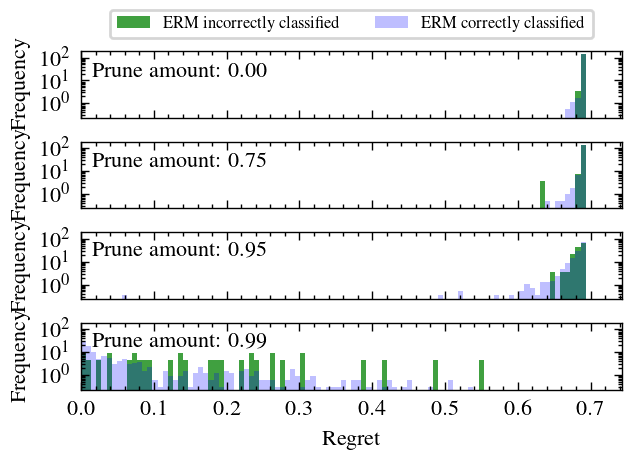

In [7]:
# Regret for ERM correctly classifed samples
bins = np.linspace(0.0, np.log(2), 100)
fig, axs = plt.subplots(len(df_dict), 1, dpi=200, sharex=True, sharey=True)

for i, (prune_amount, df) in enumerate(df_dict.items()):
    regret_for_correct = df[df["erm_is_correct"] == True]["pnml_regret"]
    regret_for_incorrect = df[df["erm_is_correct"] == False]["pnml_regret"]

    ax = axs[i]
    ax.hist(
        regret_for_incorrect,
        bins=bins,
        alpha=0.75,
        color=f"C3",
        label="ERM incorrectly classified",
        density=True
    )
    ax.hist(
        regret_for_correct,
        bins=bins,
        alpha=0.25,
        color=f"C2",
        label="ERM correctly classified",
        density=True
    )

    ax.set_yscale("log")
    ax.set_ylabel("Frequency")
    ax.text(
        0.02,
        0.85,
        f"Prune amount: {float(prune_amount):3.2f}",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
axs[-1].set_xlabel("Regret")
axs[0].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.75),
    frameon=True,
    shadow=False,
    ncol=2,
    prop={"size": 6},
)
plt.xlim(0, np.log(2) + 0.05)
plt.tight_layout()
plt.savefig(osp.join(out_dir, "regret_hist_for_erm_correct_and_incorrect.pdf"))
plt.show()


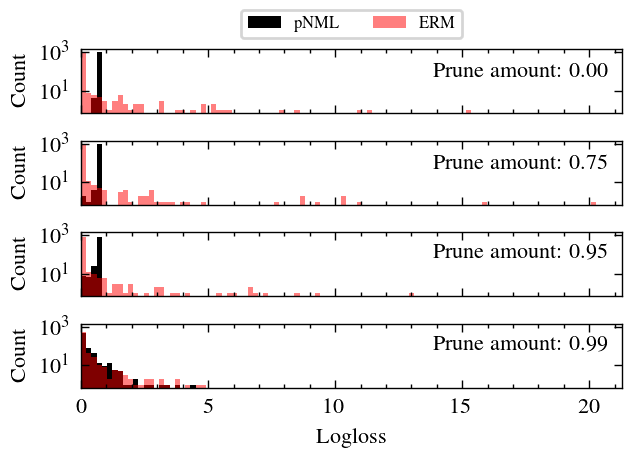

In [8]:
# Logloss
loss_max = max(
    [df["pnml_logloss"].max() for df in df_dict.values()]
    + [df["erm_logloss"].max() for df in df_dict.values()]
)
loss_min = min(
    [df["pnml_logloss"].min() for df in df_dict.values()]
    + [df["erm_logloss"].min() for df in df_dict.values()]
)

bins = np.logspace(-9, np.log10(loss_max), 100)
bins = np.linspace(0.0, loss_max, 100)


fig, axs = plt.subplots(len(df_dict), 1, dpi=200, sharex=True, sharey=True)

for i, (prune_amount, df) in enumerate(df_dict.items()):
    ax = axs[i]
    ax.hist(
        df["pnml_logloss"], bins=bins, label=f"pNML", alpha=1.0, color="C0",
    )
    ax.hist(
        df["erm_logloss"], bins=bins, alpha=0.5, color="C1", label=f"ERM",
    )

    ax.text(
        0.975,
        0.8,
        f"Prune amount: {float(prune_amount):3.2f}",
        ha="right",
        va="top",
        transform=ax.transAxes,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Count")
axs[0].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.75),
    frameon=True,
    shadow=False,
    ncol=2,
    prop={"size": 6},
)
axs[-1].set_xlabel(f"Logloss")
axs[-1].set_xlim(left=0.0)
plt.tight_layout()
plt.savefig(osp.join(out_dir,'logloss_hist.pdf'))
plt.show()


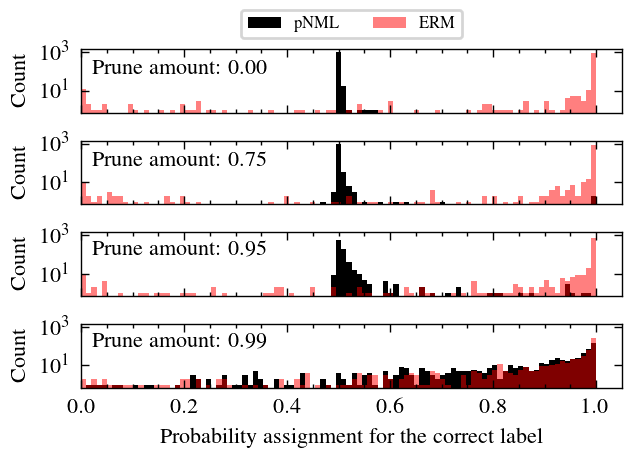

In [9]:
bins = np.linspace(0.0, 1.0, 100)


fig, axs = plt.subplots(len(df_dict), 1, dpi=200, sharex=True, sharey=True)

for i, (prune_amount, df) in enumerate(df_dict.items()):
    pnml_probs_for_correct = df.apply(
        lambda row: row["pnml_probs"][int(row["test_true_label"])], axis=1
    )
    erm_probs_for_correct = df.apply(
        lambda row: row["erm_probs"][int(row["test_true_label"])], axis=1
    )

    ax = axs[i]
    ax.hist(
        pnml_probs_for_correct, bins=bins, label=f"pNML", alpha=1.0, color="C0",
    )
    ax.hist(
        erm_probs_for_correct, bins=bins, alpha=0.5, color="C1", label=f"ERM",
    )

    ax.text(
        0.02,
        0.85,
        f"Prune amount: {float(prune_amount):3.2f}",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Count")
axs[0].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.75),
    frameon=True,
    shadow=False,
    ncol=2,
    prop={"size": 6},
)
axs[-1].set_xlabel(f"Probability assignment for the correct label")
axs[-1].set_xlim(left=0.0)
plt.tight_layout()
plt.savefig(osp.join(out_dir,'prob_for_correct_label_hist.pdf'))
plt.show()
